# Readin Timestamps and Match to a Common Timeframe

Because both the camera and eye trackers are in free-run mode rather than triggered, we have to match the timestamps between the multiple collection devices post-hoc.  This involves first converting their timestamps from internal device time to Unix time. Next, we create a common timestamp set that is uniformly measured in time. Finally, we match each device time to its nearest common timestamp time, repeating a frame in the case of dropped frames. 


## Dependencies

In [2]:
import os, stat
import numpy as np
#import utils.run_analysis as ana
import matplotlib.pyplot as plt
import datatable as dt

## Parameters

In [3]:
base_dir = '/hmet_data'
data_dir = os.path.join(base_dir, 'raw_data')
output_dir = os.path.join(base_dir, 'analysis')
target_fps = 200
cmethod = '3d_mono' #calibration method using 2d or 1d, also monocular or binoru

## Specify Directories for Exmaple

In [4]:
subject = 'ag'
trial = 'phone'
iteration='1'
trial_directory = os.path.join(data_dir, trial, subject, iteration)
analysis_folder = os.path.join(output_dir, trial, subject, iteration)

#ximea (scene cameras)
ximea_timestamp_file = os.path.join(analysis_folder, f'timestamps_ximea.tsv')
ximea_timesync_file = os.path.join(analysis_folder, f'timestamp_camsync_ximea.tsv')

#pupil (eye cameras)
#pupil_timestamp_file = os.path.join(trial_directory, 'eye_camera','000', 'pupil_timestamps.npy')
#pupil_timestamp_file = os.path.join(trial_directory, 'eye_camera','000','exports','000','pupil_positions.csv')
#pupil_annotations_file = os.path.join(analysis_folder, 'eye_camera','000', 'annotation_timestamps.npy')
#pupil_timestamp_file = os.path.join(analysis_folder, 'exports',f'pupil_positions_{cmethod}.csv')
#pupil_timestamp_file = os.path.join(analysis_folder, 'exports',f'gaze_positions_{cmethod}.csv')


## Convert to unified wall clock time

Ximea cameras collect in camera time. We need to sync this to Unix time

In [10]:
def convert_ximea_time_to_unix_time(timestamp_file, sync_file):
    '''
    Convert the ximea camera times to unix timestamps
    Params:
        timestamp_file (str): path to .csv file with ximea timesstamps
        sync_file (str): path to .csv file with sync information
    Returns:
        unix_timestamp_array (2d np array): Unix Timestamps Inferred
    '''
    with open(timestamp_file, 'r') as f:
        ts_table=list(zip(line.strip().split('\t') for line in f))
    ts_table = np.squeeze(np.array(ts_table[1:]).astype(np.double))

    with open(sync_file, 'r') as f:
        sync_table=list(zip(line.strip().split('\t') for line in f))
        
    (unix_pre, cam_pre, _) = np.array(sync_table[1][0][1:]).astype(np.double)
    (unix_post, cam_post, _) = np.array(sync_table[2][0][1:]).astype(np.double)

    #how far off have the computer and camera timestamps drifted?
    t_elapsed_unix = np.double(unix_post) - np.double(unix_pre)
    t_elapsed_cam = np.double(cam_post) - np.double(cam_pre)
    drift = np.abs(t_elapsed_unix - t_elapsed_cam)
    print(f'Time Elapsed: {t_elapsed_unix} seconds')
    print(f'Time Drift pre to post: {drift} seconds')
    
    # We assume here that time.time() in Linux's 0.001s precision is better than camera's.
    # Convert Camera timestamps to Unix timestamps.
    #first convert to [0,1]
    t_cam_converted = (ts_table[:,2] - cam_pre) / (cam_post - cam_pre)
    #then convert to wall time
    t_cam_converted = (t_cam_converted * (unix_post - unix_pre)) + unix_pre
    
    #assume time in camera is linear, and just change offset at pre.
    #t_cam_converted = ts_table[:,2] - ts_table[0,2] + unix_pre
    
    print(f'Start at {t_cam_converted[0]}, end at {t_cam_converted[-1]}')
    
    #dont add unix time to data, just send unix times
    t_cam_converted = np.append(ts_table, np.expand_dims(t_cam_converted,1),axis=1)
    
    return(t_cam_converted)

In [6]:
ximea_timestamps = convert_ximea_time_to_unix_time(ximea_timestamp_file, ximea_timesync_file)

ximea_timestamp_converted_path = os.path.join(analysis_folder,f'timestamps_converted.tsv')

#np.savetxt(od_ximea_timestamp_converted_path, od_ximea_timestamps, fmt='%10.5f', delimiter='\t')
np.savetxt(ximea_timestamp_converted_path, ximea_timestamps, fmt='%10.5f', delimiter='\t')

Time Elapsed: 91.37102216599988 seconds
Time Drift pre to post: 0.009754682000220782 seconds
Start at 2807.7722497216096, end at 2899.147620575348


In [9]:
ximea_timestamps

array([[0.00000000e+00, 5.40466000e+05, 2.82735503e+03, 2.80777225e+03],
       [1.00000000e+00, 5.40467000e+05, 2.82736003e+03, 2.80777725e+03],
       [2.00000000e+00, 5.40468000e+05, 2.82736503e+03, 2.80778225e+03],
       ...,
       [1.82760000e+04, 5.58742000e+05, 2.91873016e+03, 2.89913762e+03],
       [1.82770000e+04, 5.58743000e+05, 2.91873516e+03, 2.89914262e+03],
       [1.82780000e+04, 5.58744000e+05, 2.91874016e+03, 2.89914762e+03]])

## Get Pupil Labs Worldcam Calibrated Data

Use Converted Pupil Labs Data Structure. This gaze data has been aligned in world cam (Realsense) coordinates. To do this, after recording, drag the pupil labs folder ('000') into pupilplayer, then export. This wil create a few new files in the 000 folder, as well as an 'exports' folder with these converted files inside.   

The generated 'pupil_gaze_positions.txt' file contains a wealth of information explaining the generated files and how to interpret them.  

Specifically, for the 'norm_position_x' and y, we need to map the coordinate system to world camera coordinates.
"We use a normalized coordinate system with the origin 0,0 at the bottom left and 1,1 at the top right"

In [7]:
#create dummy pupil data as standin until calibration is completed
#do this for line 0

#create dummy eye postition data & timestamps
tstart = 2807.772 - 2 #manually for line 0
tend = 2899.148 + 2 #manually for line 0
nsamples = int(200*(tend-tstart))
data_cols = 'frame_num,x_pixel_left,y_pixel_left,x_pixel_right,y_pixel_right'
tstamp_cols = 'frame,unix_timestamp'
framenums = np.arange(0,nsamples)
timestamps = np.linspace(tstart, tend, nsamples)
pdata_timestamps_dummy = np.array((framenums,timestamps)).T
xpixels_left = np.random.randint(low=0,high=1544,size=(nsamples))
ypixels_left = np.random.randint(low=0,high=2064,size=(nsamples))
xpixels_right = np.random.randint(low=0,high=1544,size=(nsamples))
ypixels_right = np.random.randint(low=0,high=2064,size=(nsamples))
pdata_calib_dummy = np.array((framenums,xpixels_left,ypixels_left, xpixels_right, ypixels_right)).T
pupil_dummy_calibrated_data_fname = os.path.join(analysis_folder, "pupil_data_calibrated.csv")
pupil_dummy_timetamps_fname = os.path.join(analysis_folder, "pupil_timestamps.csv")

#save data file
np.savetxt(pupil_dummy_calibrated_data_fname, pdata_calib_dummy, header=data_cols,delimiter=',',fmt='%i')
#np.loadtxt(pupil_dummy_calibrated_data_fname, delimiter=',',skiprows=0)
#save timestamps file
np.savetxt(pupil_dummy_timetamps_fname, pdata_timestamps_dummy, header=tstamp_cols,delimiter=',',fmt='%f')
#np.loadtxt(pupil_dummy_timetamps_fname, delimiter=',',skiprows=0)


In [8]:
print(pupil_dummy_timetamps_fname)
#np.loadtxt(pupil_dummy_timetamps_fname, delimiter=',',skiprows=0)

/hmet_data/analysis/phone/ag/1/pupil_timestamps.csv


In [25]:
if(subject=='buddy'):
    pass
elif(cmethod in ['3d_mono','2d_mono']):
    pupil_positions = dt.fread(pupil_timestamp_file)
    pupil_positions = pupil_positions[:,[0,1,2,3,4]]
    pupil_positions[:5,:]
    pupil_eye_0 = np.array(pupil_positions)[np.where(np.array(pupil_positions)[:,2]==0)[0],:]
    pupil_eye_1 = pupil_eye_0


else:
    pupil_positions = dt.fread(pupil_timestamp_file)
    pupil_positions = pupil_positions[:,[0,1,2,3,5]]
    pupil_positions[:5,:]
    
    pupil_eye_0 = np.array(pupil_positions)[np.where(np.array(pupil_positions)[:,2]==0)[0],:]
    #pupil_eye_1 = np.array(pupil_positions)[np.where(np.array(pupil_positions)[:,2]==1)[0],:]

In [26]:
pupil_positions[:5,:]

,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x
,▪▪▪▪▪▪▪▪,▪▪▪▪,▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪
0,1.57552e+09,1,1,1,0.295251
1,1.57552e+09,1,0,0.868549,0.473657
2,1.57552e+09,2,1,1,0.295482
3,1.57552e+09,2,0,0.906568,0.473232
4,1.57552e+09,3,1,1,0.295284


In [27]:
pupil_positions[-5:,:]

,pupil_timestamp,world_index,eye_id,confidence,norm_pos_x
,▪▪▪▪▪▪▪▪,▪▪▪▪,▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪
0,1.57552e+09,34014,0,0.998458,0.246063
1,1.57552e+09,34015,0,0.998419,0.245001
2,1.57552e+09,34016,0,0.988205,0.243966
3,1.57552e+09,34017,0,0.98389,0.244337
4,1.57552e+09,34018,0,0.981173,0.244115


In [28]:
with open(ximea_timestamp_converted_path, 'r') as f:
    timestamps_ximea = list(zip(line.strip().split('\t') for line in f))
    timestamps_ximea = np.squeeze(np.array(timestamps_ximea[1:]).astype('float'))
    timestamps_ximea = timestamps_ximea[:,-1]


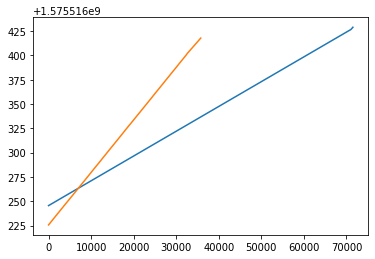

In [29]:
plt.plot(np.array(pupil_positions[:,0]))
plt.plot(timestamps_ximea)

In [30]:
pupil_eye_0[:5,:]

array([[1.57551625e+09, 1.00000000e+00, 0.00000000e+00, 8.68548902e-01,
        4.73656820e-01],
       [1.57551625e+09, 2.00000000e+00, 0.00000000e+00, 9.06568146e-01,
        4.73232255e-01],
       [1.57551625e+09, 3.00000000e+00, 0.00000000e+00, 9.41037544e-01,
        4.73489696e-01],
       [1.57551625e+09, 4.00000000e+00, 0.00000000e+00, 9.26173825e-01,
        4.73335359e-01],
       [1.57551625e+09, 5.00000000e+00, 0.00000000e+00, 8.13883440e-01,
        4.73161481e-01]])

## How Many Frames Were Lost/Skipped?

In [12]:
subject='buddy'

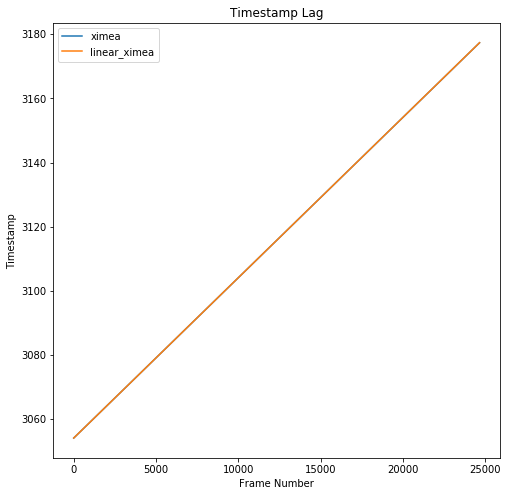

In [13]:
if(subject=='buddy'):
    pass
else:
    pupil_num='000'

    pupil_ts_eye0 = pupil_eye_0[:,0]
    pupil_ts_eye1 = pupil_eye_1[:,0]

    #pupil_ts_gaze = np.load(os.path.join(pupil_save_dir_name, pupil_num, 'gaze_timestamps.npy'))
    #pupil_ts_eye0 = np.load(os.path.join(pupil_save_dir_name, pupil_num, 'eye0_timestamps.npy'))
    #pupil_ts_eye1 = np.load(os.path.join(pupil_save_dir_name, pupil_num, 'eye1_timestamps.npy'))
    pupil_annotations = np.load(pupil_annotations_file)

#ximea timestamps
with open(ximea_timestamp_converted_path, 'r') as f:
    timestamps_ximea = list(zip(line.strip().split('\t') for line in f))
    timestamps_ximea = np.squeeze(np.array(timestamps_ximea[1:]).astype('float'))
    timestamps_ximea = timestamps_ximea[:,-1]

linear_ximea = np.arange(0,len(timestamps_ximea)*0.005, 0.005)+timestamps_ximea[0]

if(subject=='buddy'):
    pass
else:
    linear_pupil = np.arange(0, len(timestamps_ximea)*0.005, 0.005)+pupil_ts_eye0[0]

plt.figure(figsize=(8,8))
plt.plot(timestamps_ximea, label='ximea')
plt.plot(linear_ximea, label='linear_ximea')
if(subject=='buddy'):
    pass
else:
    plt.plot(pupil_ts_eye0, label='pupil_eye0')
    #plt.plot(pupil_ts_eye1, label='pupil_eye1')
    #plt.plot(pupil_ts_gaze, label='gaze')
    # plt.plot(pupil_ts_eye0, label='vid_eye0')
    # plt.plot(pupil_ts_eye1, label='vid_eye1')
    plt.plot(linear_pupil, label='linear_pupil')

    [plt.axhline(pupil_annotations[i], label='trial_marker') for i in range(len(pupil_annotations))]
    #plt.axhline(pupil_annotations[1], label='trial_marker')

plt.legend()
plt.xlabel('Frame Number')
plt.ylabel('Timestamp')
plt.title('Timestamp Lag')
plt.legend()

In [32]:
print(pupil_eye_0[0,0], timestamps_ximea[0], pupil_positions[0,0])
print(pupil_eye_0[-1,0], timestamps_ximea[-1], pupil_positions[0,-1])

1575516245.4839168 1575516225.61644 1575516245.4836128
1575516428.9683037 1575516417.81224 0.2952511230348283


We've lost a decent number of ximea frames, but pupil looks pretty good. Lets ID where the missing frames are first.

In [33]:
d_t = timestamps_ximea[1:] - timestamps_ximea[:-1]
pfl = len(d_t[d_t >= 0.01])/len(d_t)
print(f'Percentage Frames Dropped: {pfl}')

Percentage Frames Dropped: 0.0037186154448358775


## Task Marking

*** FOR THIS PRELIMINARY DATA WHICH HAS NO TASK END MARKER ONLY ***   
*** When we move to a second calibration AFTER the task, need to change this code ***

The LAST pupil annotation should be the beginning of the task, and all data AFTER that is task data. Mark it as such.

In [18]:
if(subject == 'buddy'):
    start_task_time = timestamps_ximea[0]
    end_task_time = timestamps_ximea[-1]
# elif(trial == 'cell_phone_1'):
#     start_task_time = pupil_annotations[-2]
#     end_task_time = pupil_annotations[-1]
else:
    start_task_time = pupil_annotations[-1]
    end_task_time = timestamps_ximea[-1]

## Create Non-Lossy Timeframe & Assign Pupil & Ximea Frames to it
For now, frame numbers are simply repeated if there is a frame drop. This seems better than interpolating an image, but will ask Bruno about this

In [14]:
if(subject == 'buddy'):
    start_timestamp = timestamps_ximea[0]
    end_timestamp = timestamps_ximea[-1]
else:
    start_timestamp = np.max((timestamps_ximea[0], pupil_ts_eye0[0], pupil_ts_eye1[0]))
    end_timestamp = np.min((timestamps_ximea[-1], pupil_ts_eye0[-1], pupil_ts_eye1[-1]))
common_timeline = np.arange(start_timestamp, end_timestamp, 1./target_fps)

In [15]:
len(timestamps_ximea)

24650

In [16]:
len(common_timeline)

24645

In [19]:
ximea_common_timeline_match = np.zeros_like(common_timeline)
pupil_eye0_common_timeline_match = np.zeros_like(common_timeline)
pupil_eye1_common_timeline_match = np.zeros_like(common_timeline)
during_calibration = np.zeros_like(common_timeline)
during_task = np.zeros_like(common_timeline)

for i, t in enumerate(common_timeline):
    ximea_common_timeline_match[i] = np.argmin(np.abs(timestamps_ximea - t))
    if((t > start_task_time) and (t < end_task_time)):
        during_task[i] = 1
    if(subject!='buddy'):   
        pupil_eye0_common_timeline_match[i] = np.argmin(np.abs(pupil_ts_eye0 - t))
        pupil_eye1_common_timeline_match[i] = np.argmin(np.abs(pupil_ts_eye1 - t))
    #mark calibration later
        #during_calibration

In [20]:
nframes = len(np.where(during_task ==1)[0])
print(f'{nframes/target_fps} Seconds of Task')

123.22 Seconds of Task


## Save Timeframe and Marks for Later Use

Our new timeline can be used to align pupil labs data to our camera data and create movies for spatiotemporal analysis!

In [21]:
if(subject=='buddy'):
    common_timeline_table = np.array((common_timeline, ximea_common_timeline_match, during_task, during_calibration)).T
    common_timeline_table_colnames = 'common_timeline\tximea_frame\tduring_task\tduring_calibration'
else:
    common_timeline_table = np.array((common_timeline, ximea_common_timeline_match, pupil_eye0_common_timeline_match, pupil_eye1_common_timeline_match, during_task, during_calibration)).T
    common_timeline_table_colnames = 'common_timeline\tximea_frame\tpupil_eye0_frame\tpupil_eye1_frame\tduring_task\tduring_calibration'
    
common_timeline_file_human = os.path.join(analysis_folder,f'common_timeline_{cmethod}.tsv')
np.savetxt(common_timeline_file_human, common_timeline_table, delimiter='\t', header=common_timeline_table_colnames)
common_timeline_file = os.path.join(analysis_folder,f'common_timeline{cmethod}.npy')
np.save(common_timeline_file, common_timeline_table)

In [22]:
common_timeline_file

'/hmet_data/analysis/book/ag/1/common_timeline3d_mono.npy'

## Run Script on All Trials

I put all the code in a nice script! Run this script on all our trials to create respective timestamps for each

In [42]:
import itertools as it
import read_match_timestamps as rmt
import imp
imp.reload(rmt)

subjects = ['buddy', 'ag']
tasks = ['chat','book','cellphone', 'laptop'] 
repititions = ['1']
iterator = it.product(subjects, tasks, repititions)

for iteration in iterator:
    subject, task, rep = iteration
    trial = f'{task}_{rep}'
    print('*')
    if(os.path.isdir(os.path.join(base_dir,'raw_data', subject, trial))):
        table = rmt.read_match_timestamps(base_dir, target_fps, subject, trial, num_cameras=1)

*
Folder /data_repo/bravo/analysis/buddy/chat_1/ Already Made!
Time Elapsed: 60.658884048461914 seconds
Time Drift pre to post: 0.012878471538101621 seconds
Start at 1575571432.7209806, end at 1575571491.6346958


ValueError: File /data_repo/bravo/raw_data/buddy/chat_1/pre`/eye_camera/000/exports/000/pupil_positions.csv` does not exist

In [12]:
idx = np.array((1,3,5))
a = np.array((10,11,12,13,14,15,16))
a.take(idx)

array([11, 13, 15])